In [1]:
import os
import gc
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tifffile as tiff
import cv2 as cv
import albumentations as albu

import pathlib, sys, os, random, time
import numba, gc, cv2
import rasterio
from rasterio.windows import Window

from tqdm.notebook import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.utils.data as D
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import segmentation_models_pytorch as smp

from albumentations import (
    Compose, OneOf, Normalize, HorizontalFlip, VerticalFlip, RandomRotate90, Transpose, ShiftScaleRotate, IAAAdditiveGaussianNoise, IAAPerspective,
    CLAHE, RandomBrightness, RandomGamma, IAASharpen, Blur, MotionBlur, RandomContrast, HueSaturationValue, VerticalFlip,
    RandomRotate90, OneOf, Resize, Rotate, RandomBrightnessContrast, Lambda
    )
from albumentations.pytorch import ToTensorV2, ToTensor
#from albumentations import *

%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
TEST_DATA_DIR = '/home/arti/DL/HuBMAP/Data/'
MODEL_SAVE_DIR = "/home/arti/DL/HuBMAP/OUTPUTS/models/"
TILE_SIZE = 256
REDUCE_RATE = 4
SEED = 42
BATCH_SIZE = 16
NUM_EPOCHS = 20

WINDOW=1024
MIN_OVERLAP=32
NEW_SIZE=256

torch.cuda.empty_cache()

In [5]:
def make_grid(shape, window=256, min_overlap=32):
    """
        Return Array of size (N,4), where N - number of tiles,
        2nd axis represente slices: x1,x2,y1,y2 
    """
    x, y = shape
    nx = x // (window - min_overlap) + 1
    x1 = np.linspace(0, x, num=nx, endpoint=False, dtype=np.int64)
    x1[-1] = x - window
    x2 = (x1 + window).clip(0, x)
    ny = y // (window - min_overlap) + 1
    y1 = np.linspace(0, y, num=ny, endpoint=False, dtype=np.int64)
    y1[-1] = y - window
    y2 = (y1 + window).clip(0, y)
    slices = np.zeros((nx,ny, 4), dtype=np.int64)
    
    for i in range(nx):
        for j in range(ny):
            slices[i,j] = x1[i], x2[i], y1[j], y2[j]    
    return slices.reshape(nx*ny,4)

@numba.njit()
def rle_numba(pixels):
    size = len(pixels)
    points = []
    if pixels[0] == 1: points.append(0)
    flag = True
    for i in range(1, size):
        if pixels[i] != pixels[i-1]:
            if flag:
                points.append(i+1)
                flag = False
            else:
                points.append(i+1 - points[-1])
                flag = True
    if pixels[-1] == 1: points.append(size-points[-1]+1)    
    return points

def rle_numba_encode(image):
    pixels = image.flatten(order = 'F')
    points = rle_numba(pixels)
    return ' '.join(str(x) for x in points)

def rle_decode(mask_rle, shape=(256, 256)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order='F')

def visualize_tensor(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [3]:
# ====================================================
# ValTransforms
# ====================================================
def ValTransforms():
    return Compose([
        Resize(256,256),
        Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        ),
            #ToTensorV2(),
    ])

In [4]:
model = smp.Unet(encoder_name='se_resnext50_32x4d', 
                 encoder_weights='imagenet', 
                 activation='sigmoid')

model = torch.load(os.path.join(MODEL_SAVE_DIR, 'best_model_sub.pth'), map_location=torch.device(device))
model.to(device);
model.eval();

In [10]:
ls

0486052bb.tiff            Predict.ipynb   Train.ipynb
Mask_Encode_Decode.ipynb  submission.csv  Unet_HuBMAP.ipynb


In [17]:
identity_trfm = Lambda(image = lambda x,cols=None,rows=None : x)
identity = rasterio.Affine(1, 0, 0, 0, 1, 0)

transforms = ValTransforms()

p = pathlib.Path('/home/arti/DL/BasicCode/Segmentations/')
subm = {}

for i, filename in tqdm(enumerate(p.glob('*.tiff')), 
                        total = len(list(p.glob('*.tiff')))):
    
    print(f'{i+1} Predicting {filename.stem}')
    
    dataset = rasterio.open(filename.as_posix(), transform = identity)
    print(dataset.shape)
    slices = make_grid(dataset.shape, window=WINDOW, min_overlap=MIN_OVERLAP)
    preds = np.zeros(dataset.shape, dtype=np.uint8)
    
    for (x1,x2,y1,y2) in slices:
        image = dataset.read([1,2,3],
                    window=Window.from_slices((x1,x2),(y1,y2))) 
        
        # SLICE TO TORCH.TENSOR
        image = np.moveaxis(image, 0, -1)  
        # resize and normalize
        image = transforms(image=image)['image']
        # equivalent ToTensorV2
        image = np.moveaxis(image, -1, 0)
        image = torch.from_numpy(image)
        
        with torch.no_grad():
            # (3,256,256) -> (1,3,256,256)
            image = image.float().to(device)[None]
            
            score = model(image)
            score = score.cpu().numpy()[0][0]   
                    
            # UPscaling 256->1024
            score = cv2.resize(score, (WINDOW, WINDOW)) 
            
            #print(np.mean(score), np.median(score))
            
        
        preds[x1:x2,y1:y2] = (score > 0.5).astype(np.uint8)      
    subm[i] = {'id':filename.stem, 'predicted': rle_numba_encode(preds)}
    del preds
    gc.collect();

/home/arti/anaconda3/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:2964: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  "Using lambda is incompatible with multiprocessing. "


/home/arti/anaconda3/lib/python3.7/site-packages/rasterio/__init__.py:207: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


1 Predicting 0486052bb
(25784, 34937)



In [18]:
submission = pd.DataFrame.from_dict(subm, orient='index')
submission.to_csv('submission.csv', index=False)
submission

,id,predicted
0,0486052bb,101727681 20 101753453 37 101779234 43 1018050...


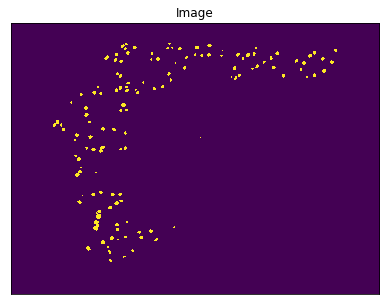

In [20]:
image = rle_decode(submission.loc[0].predicted, shape=(25784, 34937))
visualize_tensor(image=image)